#1.0 Import & setup

In [84]:
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# text to vectors
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer


from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM


In [2]:
data_file = "https://raw.githubusercontent.com/nirmalie/CM4107/main/movie_data_cat.csv"
df = pd.read_csv(data_file,  encoding='utf-8')

# load the two datasets we will explore and lets see the shape of them
print("df1 shape: ", df.shape)
df.head(5)


df1 shape:  (50000, 2)


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",pos
1,OK... so... I really like Kris Kristofferson a...,neg
2,"***SPOILER*** Do not read this, if you think a...",neg
3,hi for all the people who have seen this wonde...,pos
4,"I recently bought the DVD, forgetting just how...",neg


## 1.1  clean & investigate the data

We have to start by mapping the class labels properly - we can also see what a 0 or 1 represent once we have mapped them.

In [3]:
# this is the whole dataset for the final models and results to be built on

class_mapping = {label:idx for idx,label in enumerate(np.unique(df['sentiment']))}

print("class_mapping:" , class_mapping)

# turn 'neg' and 'pos' into 0 or 1

df['sentiment'] = df['sentiment'].map(class_mapping)
df.head()

class_mapping: {'neg': 0, 'pos': 1}


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


* Create a pre-processor that can remove all the fluff from the review.

* Download the stop words and assign 'stop' to them.

* Create two tokenizer methods- 
  * simply create tokens 
  * stemm the word then create tokens
  

In [4]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # remove all html markup ; re.sub(A, B, C) will Replace A with B in the string C.
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons re.findall(A, B) | Matches all instances of an expression A in a string B and returns them in a list.
    
    # remove the non-word chars '[\W]+'
    # append the emoticons to end 
    # convert all to lowercase
    # remove nose char for consistency
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', '')) 
    return text

nltk.download('stopwords')
#get the english stopwords
stop = set(stopwords.words('english'))
print("Number of stopwords:", len(stop))

stemmer = SnowballStemmer("english")

def tokenizer(text):
       return text.split()
 

def tokenizer_stemmer(text):
    return [stemmer.stem(word) for word in tokenizer(text)]


Number of stopwords: 179


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from sklearn.preprocessing import FunctionTransformer

def text_cleanup(X, lowercase):  #lowercase: True to convert to lowercase or False to leave case as they are
    # print('in text_cleanup...')
    # print('lowercase:', lowercase)
    XX = np.copy(X)  # get copy of the data
    for index, text in enumerate(XX):
        text = re.sub('<[^>]*>', '', text) # remove all html markup ; re.sub(A, B, C) will Replace A with B in the string C.
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons re.findall(A, B) | Matches all instances of an expression A in a string B and returns them in a list.
        
        # remove the non-word chars '[\W]+'
        # append the emoticons to end 
        # conditionally convert all to lowercase
        # remove nose char for consistency
        if lowercase:
            text = text.lower()
        text = (re.sub('[\W]+', ' ', text) +
                ' '.join(emoticons).replace('-', ''))
        XX[index] = text

    return XX


#creating text_cleanup object using FunctionTransformer
text_cleanup_preprocessor = FunctionTransformer(text_cleanup, kw_args={'lowercase': True})

### 1.1.1 investigate preprocessing steps

Lets see how these tokenisers work.

We have to push the preprocessor through FunctionTransformer so that it can be used within our pipeline.

In [139]:
temp_item = "this movie is so bad i couldnt help but fall asleep it was worse than being in a lecture while you have had 0 hours of sleep and want to learn the topic"
clean_me = ["OMG ;) THIS MOVIE <>??? WAS INSAN333 there were so many cool ^-^ scenes :}@@£$"]
print(text_cleanup(clean_me, lowercase=True))
print(text_cleanup(clean_me, lowercase=False))
print(tokenizer(temp_item))
print(tokenizer_stemmer(temp_item))

['omg this movie was insan333 there were so many cool scenes ;)']
['OMG THIS MOVIE WAS INSAN333 there were so many cool scenes ;)']
['this', 'movie', 'is', 'so', 'bad', 'i', 'couldnt', 'help', 'but', 'fall', 'asleep', 'it', 'was', 'worse', 'than', 'being', 'in', 'a', 'lecture', 'while', 'you', 'have', 'had', '0', 'hours', 'of', 'sleep', 'and', 'want', 'to', 'learn', 'the', 'topic']
['this', 'movi', 'is', 'so', 'bad', 'i', 'couldnt', 'help', 'but', 'fall', 'asleep', 'it', 'was', 'wors', 'than', 'be', 'in', 'a', 'lectur', 'while', 'you', 'have', 'had', '0', 'hour', 'of', 'sleep', 'and', 'want', 'to', 'learn', 'the', 'topic']


### 1.1.2 more processing

Lets get a smaller amount of data - training will be less accurate but the dataset pre-processing should be sufficient / correlate with larger datasets.

In [6]:
smaller_df = df.sample(frac=0.09, replace=False, random_state=1)
# remove the HTML and punctuation to speed up text processing

smaller_df['review'] = smaller_df['review'].apply(preprocessor)

X = smaller_df.loc[:, "review"].values
y = smaller_df.loc[:, "sentiment"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=42,
                                                          test_size=0.30, # 30% for testing
                                                          stratify=y)
print("Sample of Training data:", X_train.shape)
print("Sample of Test data:", X_test.shape)

Sample of Training data: (3150,)
Sample of Test data: (1350,)


## 1.2 Dataset visualisations

Lets see what the dataset looks like, we can clean the data manually here or call preprocessor and then lets see the total size.

We also want to see the average words per feature and how the label distrubution is.

In [7]:
df=pd.DataFrame(X_train, columns=['review'])
df.head()
VOCAB_SIZE = set(df['review'].str.replace('[^a-zA-Z ]', '').str.lower().str.split(' ').sum())
print("Vocabulary approx size: ")
len(VOCAB_SIZE)

<ipython-input-7-7789f635b4e5>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  VOCAB_SIZE = set(df['review'].str.replace('[^a-zA-Z ]', '').str.lower().str.split(' ').sum())


Vocabulary approx size: 


31085

Review length: 
Mean 1266.97 words (958.829856) in a review


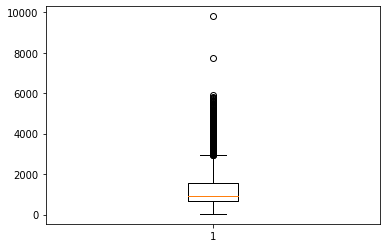

In [8]:
# lets see the length of the reviews
from matplotlib import pyplot

# Summarize review length
print("Review length: ")
result = [len(x) for x in df.review]
print("Mean %.2f words (%f) in a review" % (np.mean(result), np.std(result)))

AVG_REVIEW_LEN = np.mean(result)

# plot review length
pyplot.boxplot(result)
pyplot.show()

Counter({0: 1604, 1: 1546})


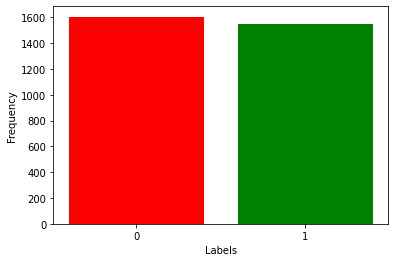

In [9]:
# Import the Counter class from the collections module and the matplotlib library.
from collections import Counter
import matplotlib.pyplot as plt

# The data points and the labels in your X_train dataset.

# Calculate the label distribution in the X_train dataset using the Counter class.
label_distribution = Counter(y_train)
# Print the label distribution.
print(label_distribution)
# Output: Counter({1: 5, 0: 5})

# Graph the label distribution using the matplotlib library.
plt.bar(label_distribution.keys(), label_distribution.values(), color=['red', 'green'])
plt.xticks([0, 1])
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()


Here is an inital look into the distrubution of labels in the dataset - shows that there is a slight imbalance of around 50 labels

And the previous graph shows the average length - some variance there too, however we use CV folds to help mitigate the issues some training instances might have with highly imbalanced or varied training data.

In [140]:
print(X_train[1])
print(y_train[1])

print(X_train[3])
print(y_train[3])

ok so the following review is more of a synopsis more so than really containing any spoilers but better safe than sorry so as to avoid being blacklisted right right consider yourselves officially warned and read on in this parody tribute to the greatest time in horror movie history the 1980 s a group of stupid teens are getting together to host a seance in the house of the notorious murder mcgee who butchered his entire family a few years back and buried them in the back yard as i m sure you can guess things go from bad to worse faster than you can say where s the beef and in typical 80 s horror movie fashion the deaths are bloody the dialogue is cheesy and beautiful women are taking off their clothes every chance they get good times no clique or 80 s horror movie clichéd characterizations are left unrepresented here in fact no stone was left unturned at all we have the cool hero his innocent girlfriend the goth chick the tough thug think john bender the hot blonde who keeps losing her

### 1.2.1 Coolest visualisation in the class?

Lets createa a cool visualisation to see what some of the words for a positive and negative feature look like.

<function matplotlib.pyplot.show(*args, **kw)>

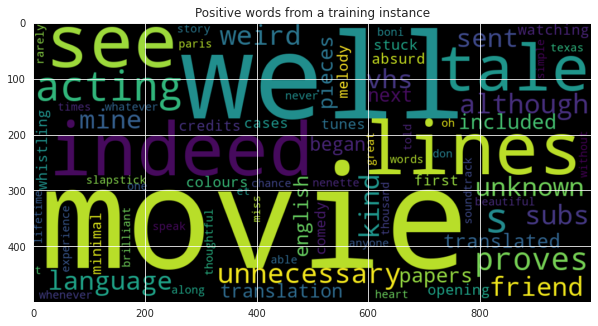

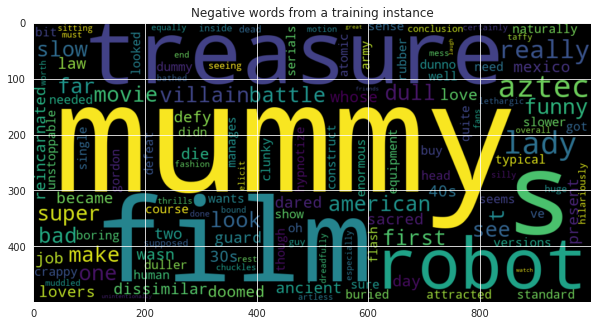

In [141]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range (50):
  if y_train[i] == 1:
    positive_text=X_train[i]

WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.title("Positive words from a training instance")
plt.show

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for x in range (50):
  if y_train[x] == 0:
    negative_text=X_train[x]

WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(negative_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.title("Negative words from a training instance")

plt.show

The above is a wordcloud of two different sentiments one positive one negative, this can give us an idea of how a model could learn certain patterns or words to determine sentiment from patterns. 

**Obviously we dont train just on words as we have to vectorise the data**

# 2.0 Create inital pipeline

Lets create a pipeline so that we can perform a gridsearch to find the most optimal pre-processing parameters - these will vary from model to model so I have to be cautious.

In [ ]:
param_grid = [{
    'vect__ngram_range': [(1,1),(1,2)], # extract 2-grams of words in addition to the 1-grams (1 word vs 2 word combos)
    'vect__tokenizer': [tokenizer, tokenizer_stemmer], # a tokeniser and the stemmer 
    'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
    'tcp__kw_args': [{'lowercase': True}, {'lowercase': False}]  # case insensitive or not parameters for our custom transformer
  }]

#Sentiment classification with a neural net
pipe_ = Pipeline([
                  ('tcp', text_cleanup_preprocessor),
                  ('vect', TfidfVectorizer()),
                  ('clf', MultinomialNB(alpha=1.0, class_prior=None))
  ])
                
grid_senti = GridSearchCV(pipe_, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=1) 

grid_senti.fit(X_train, y_train)

In [16]:
print('best parameters are: ', grid_senti.best_params_)
print("Best score is: ", grid_senti.best_score_)
best_ver = grid_senti.best_estimator_
print(X_train.shape)
print("Test accuracy from the model is: ", best_ver.score(X_test, y_test))

best parameters are:  {'tcp__kw_args': {'lowercase': True}, 'vect__ngram_range': (1, 2), 'vect__stop_words': {'being', "aren't", 'below', 'them', 'then', 'she', 'under', 'here', 'having', 'above', 'other', 'some', 'any', 'haven', 'ma', 'our', 'while', 'whom', 'am', 'doesn', 'he', 'few', 'which', 'so', "it's", 'where', 's', "you'd", 'you', 'couldn', 'shouldn', 'out', 'an', "mightn't", 'once', 'but', 'such', "she's", 'ourselves', 'herself', 'itself', 'shan', "needn't", 'be', "hasn't", "wouldn't", 'because', 'the', 'don', 'doing', 'about', "you'll", "should've", "haven't", 'had', 't', 'of', 'aren', 'me', 'yourself', 'ours', 'has', 'when', "shouldn't", "don't", 'just', "didn't", 'wasn', 'between', 'its', 'again', 'ain', 'mightn', 've', "wasn't", 'or', "you've", 'during', 'll', 'this', 'more', 'off', 'against', 'there', 'your', 'at', 'y', 'mustn', 'further', 'my', 'needn', 'theirs', 'these', 'most', 'than', 'were', 'now', "couldn't", 'weren', 'himself', 'into', 'both', 'hadn', 'yourselves',

## 2.1 More pipelines & parameters

This is a good start however we can further tune these paremter searches to find other more optimal results. 

It must be pointed out we only used 5 cross-validation splits.

1. ngram_range best = (1,2) {unigrams + bigrams)
2. lowercase = true 
3. tokenizer + stemmer is best

However, we have to be warey here - lets see the whole classification report. It must be noted .best_score_ from the above gridsearch uses the average of the 5-folds.

Lets investigate what affect other parameters have, specifically parameteres that limit the amount of words (dimension reduction) that are allowed into the vectorizor. ie: min and max df and max_features.

In [143]:
param_grid0 = [{
    'vect__ngram_range': [(1,2)], # extract 2-grams of words in addition to the 1-grams (1 word vs 2 word combos)
    'vect__tokenizer': [tokenizer_stemmer], # a tokeniser and the stemmer 
    'vect__stop_words': [stop], # use the stop dictionary of stopwords or not
    'vect__max_features': (500, 1000, None), # a vocabulary that only consider the top max_features ordered by term frequency
    'vect__min_df': (7, 10), # ignore terms that have a document frequency strictly lower than )
    'vect__max_df': (0.75, 0.95),
    'tcp__kw_args': [{'lowercase': False}],  # case insensitive or not parameters for our custom transformer
  }]


pipeline0 = Pipeline([
                  ('tcp', text_cleanup_preprocessor),
                  ('vect', TfidfVectorizer()),
                  ('clf',  MultinomialNB(alpha=1.0, class_prior=None))

  ])

grid_senti0 = GridSearchCV(pipeline0, param_grid0,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=1)
grid_senti0.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tcp',
                                        FunctionTransformer(func=<function text_cleanup at 0x7fcae03929d0>,
                                                            kw_args={'lowercase': True})),
                                       ('vect', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=1,
             param_grid=[{'tcp__kw_args': [{'lowercase': False}],
                          'vect__max_df': (0.75, 0.95),
                          'vect__max_features': (500, 1000, None),
                          'vect__min_df': (7, 10),
                          'vect__n...range': [(1, 2)],
                          'vect__stop_words': [{'a', 'about', 'above', 'after',
                                                'again', 'against', 'ain',
                                                'all', 'am', 'an', 'and', 'any',
                                              

In [144]:
print('best parameters are: ', grid_senti0.best_params_)
print("Best score is: ", grid_senti0.best_score_)
best_ver0 = grid_senti0.best_estimator_

print("Test accuracy from all the models test data is: ", best_ver0.score(X_test, y_test))


best parameters are:  {'tcp__kw_args': {'lowercase': False}, 'vect__max_df': 0.75, 'vect__max_features': None, 'vect__min_df': 7, 'vect__ngram_range': (1, 2), 'vect__stop_words': {'being', "aren't", 'below', 'them', 'then', 'she', 'under', 'here', 'having', 'above', 'other', 'some', 'any', 'haven', 'ma', 'our', 'while', 'whom', 'am', 'doesn', 'he', 'few', 'which', 'so', "it's", 'where', 's', "you'd", 'you', 'couldn', 'shouldn', 'out', 'an', "mightn't", 'once', 'but', 'such', "she's", 'ourselves', 'herself', 'itself', 'shan', "needn't", 'be', "hasn't", "wouldn't", 'because', 'the', 'don', 'doing', 'about', "you'll", "should've", "haven't", 'had', 't', 'of', 'aren', 'me', 'yourself', 'ours', 'has', 'when', "shouldn't", "don't", 'just', "didn't", 'wasn', 'between', 'its', 'again', 'ain', 'mightn', 've', "wasn't", 'or', "you've", 'during', 'll', 'this', 'more', 'off', 'against', 'there', 'your', 'at', 'y', 'mustn', 'further', 'my', 'needn', 'theirs', 'these', 'most', 'than', 'were', 'now',

GridSearch CV gets an average of all 5 scores lets use the cross_eval to see what values each fold had.

## 2.2 SelectKbest paramtere tuning

SelectKbest is capable of dimension reduction and it does this by selecting the "K" top features from a dataset.

Lets inspect the effect this has on our model.

In [145]:
from sklearn.feature_selection import SelectKBest, chi2

param_grid1 = [{
    'vect__ngram_range': [(1,2)],
    'vect__tokenizer': [tokenizer_stemmer], # a tokeniser and the stemmer 
    'vect__stop_words': [stop], # use the stop dictionary of stopwords or not
    'tcp__kw_args': [{'lowercase': False}],
    'chi__k' : [(50), (100), (250), (300)],
}]

pipeline1 = Pipeline([
                  ('tcp', text_cleanup_preprocessor),
                  ('vect', TfidfVectorizer(min_df=7, max_df=0.75)),
                  ('chi', SelectKBest(chi2)),
                  ('clf',  MultinomialNB(alpha=1.0, class_prior=None))

  ])

grid_senti1 = GridSearchCV(pipeline1, param_grid1,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [147]:
grid_senti1.fit(X_train, y_train)
print('best parameters are: ', grid_senti1.best_params_)
print("Best score is: ", grid_senti1.best_score_)
best_ver1 = grid_senti1.best_estimator_

print("Test accuracy from all the models test data is: ", best_ver1.score(X_test, y_test))


cv_results_df = pd.DataFrame(grid_senti1.cv_results_)
print(cv_results_df[["param_chi__k","mean_test_score"]])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn(


best parameters are:  {'chi__k': 250, 'tcp__kw_args': {'lowercase': False}, 'vect__ngram_range': (1, 2), 'vect__stop_words': {'being', "aren't", 'below', 'them', 'then', 'she', 'under', 'here', 'having', 'above', 'other', 'some', 'any', 'haven', 'ma', 'our', 'while', 'whom', 'am', 'doesn', 'he', 'few', 'which', 'so', "it's", 'where', 's', "you'd", 'you', 'couldn', 'shouldn', 'out', 'an', "mightn't", 'once', 'but', 'such', "she's", 'ourselves', 'herself', 'itself', 'shan', "needn't", 'be', "hasn't", "wouldn't", 'because', 'the', 'don', 'doing', 'about', "you'll", "should've", "haven't", 'had', 't', 'of', 'aren', 'me', 'yourself', 'ours', 'has', 'when', "shouldn't", "don't", 'just', "didn't", 'wasn', 'between', 'its', 'again', 'ain', 'mightn', 've', "wasn't", 'or', "you've", 'during', 'll', 'this', 'more', 'off', 'against', 'there', 'your', 'at', 'y', 'mustn', 'further', 'my', 'needn', 'theirs', 'these', 'most', 'than', 'were', 'now', "couldn't", 'weren', 'himself', 'into', 'both', 'hadn

### 2.2.1 Investigate selectKbest results

Lets see what is happeing with increasing kbest values.

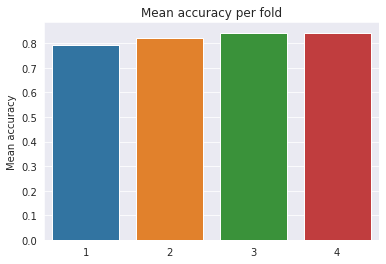

In [148]:
# Import the necessary modules
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the visualizations
sns.set_style("darkgrid")

# Extract the mean accuracy scores for each fold
mean_accuracies = grid_senti1.cv_results_["mean_test_score"]

# Create a barplot of the mean accuracy scores for each fold
sns.barplot(x=list(range(1, len(mean_accuracies)+1)), y=mean_accuracies)

# Add labels and title to the plot
plt.xlabel("")
plt.ylabel("Mean accuracy")
plt.title("Mean accuracy per fold")

# Show the plot
plt.show()


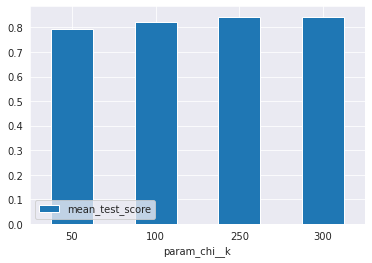

In [149]:
cv_all_results_df = pd.DataFrame(grid_senti1.cv_results_)
feature_selection_results = cv_results_df[["param_chi__k","mean_test_score"]]
feature_selection_results.plot.bar(y='mean_test_score', x="param_chi__k", rot=0)
ax = plt.gca()
ax.legend(loc="lower left")
plt.show()

k = 250 seems to give the highest accuracy with the current NB model.

In [150]:
cross_val_score(best_ver1, X_train, y_train, cv=10)
# lets see all the results from the folds, rather than just the average that best_score gives

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 

array([0.85079365, 0.86984127, 0.83174603, 0.84444444, 0.81269841,
       0.86031746, 0.82539683, 0.85714286, 0.83809524, 0.86349206])

With the crossvalscore function and the number of folds(cv=10) being larger here we can see some scores of higher values 86% but the average seems to be about what was expected given what best_score returned earlier.

## 2.3 Visualise the existing pipeline

We can visualise the structure of the pipeline (how the processes are applied and in which order)

In [151]:
# pipe with optimal params so far
pipe = make_pipeline(text_cleanup_preprocessor,TfidfVectorizer(min_df=7, max_df=0.75), SelectKBest(k=250), MultinomialNB(alpha=1.0, class_prior=None))

In [152]:
# a cool visualisation here to see the current best found params for NB model
from sklearn import set_config
set_config(display="diagram")
pipe


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function text_cleanup at 0x7fcae03929d0>,
                                     kw_args={'lowercase': True})),
                ('tfidfvectorizer', TfidfVectorizer(max_df=0.75, min_df=7)),
                ('selectkbest', SelectKBest(k=250)),
                ('multinomialnb', MultinomialNB())])

In [153]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


Lets plot and see how the training accuracy improves during training.


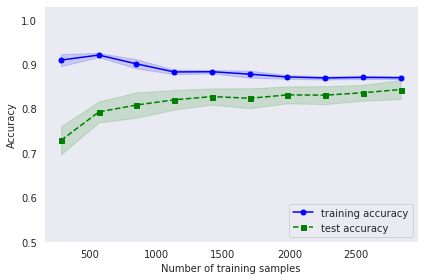

In [154]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='test accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.03])
plt.tight_layout()
plt.show()

# 3.0 Create multiple pipelines of different models

Here we created a function so that it is possible to conduct similar experiments on different types of models, we can run multiple models while simultaneously getting their optimal parameters.

In [171]:
# pipe = make_pipeline(text_cleanup_preprocessor,TfidfVectorizer(min_df=7, max_df=0.75), SelectKBest(k=250), MultinomialNB(alpha=1.0, class_prior=None))

import copy

best_models = []
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def gsearch(models, train_data, train_target, test_data, test_target, text_vectoriser, parameter_grid, scoring="accuracy", folds=5):
    """
    Performs grid searches for models and returns the training and test accuracies. 
    """
    dat = []
    ##iterate through each model
    for name, model, params in models:
        # add any model parameters to the parameter grid
        param_grid = copy.deepcopy(parameter_grid)  # deep copy so that 'parameter_grid' does not maintain a reference to 'param_grid'
        for param_name, param_options in params:
            param_grid[0]['model__' + param_name] = param_options

        # the pipeline
        if len(train_data) > 300:
          pipe_tfidf = Pipeline([('clean', text_cleanup_preprocessor),
                                ('vector', TfidfVectorizer()),
                                ('selector', SelectKBest(chi2, k = 250)),
                                ('model',  model)])
        else:
          pipe_tfidf = Pipeline([('clean', text_cleanup_preprocessor),
                                ('vector', TfidfVectorizer()),
                                ('model',  model)])
        pipelines = []
        pipelines.append(pipe_tfidf)

        # grid search cv
        gs_sentiment_classification = GridSearchCV(pipe_tfidf, param_grid,
                              scoring=scoring,
                              cv=folds,
                              verbose=1,
                              n_jobs=-1)
        
        gs_sentiment_classification.fit(train_data, train_target)

        print('Best parameter set: %s ' % gs_sentiment_classification.best_params_)
        train_score = gs_sentiment_classification.best_score_
        print('CV Accuracy: %.3f' % train_score)


        clf = gs_sentiment_classification.best_estimator_
        best_models.append(clf)
        pred = clf.predict(X_test)

        precision = precision_score(y_true=y_test, y_pred=pred)
        recall = recall_score(y_true=y_test, y_pred=pred)
        f1 = f1_score(y_true=y_test, y_pred=pred)



        test_score = clf.score(test_data, test_target)
        print("Precision score is: ", precision)
        print("Recall score is is: ", recall)
        print("f1 score is: ", f1)
        print('Test Accuracy: %.3f\n' % test_score)
        dat.append([name, train_score, test_score, precision, recall, f1])

    return pd.DataFrame(dat, columns=['Model', 'Train Accuracy', 'Test Accuracy', 'precision', 'recall', 'f1'])


In [172]:
print(X_test.shape)

(837,)


## 3.1 Add models & their model parameters

Here we make a list and then we add models which are in the format as follows.

String, Model method, List of model parameters (2d list as we can have multiple values for each parameter)

In [ ]:
models = []
models.append(('LR', LogisticRegression(), [('max_iter', [128]), ('solver', [('lbfgs')]), ('multi_class', ['auto']), ('C', [(1), (0.5)])]))
models.append(('SVM', SVC( gamma=0.1, C=1.0), [('kernel', [('linear'), ('poly')])]))
models.append(('ANN', MLPClassifier(), [('max_iter', [1024]), ('solver', [('lbfgs')]), ('activation', [('relu'), ('identity'),('tanh')])])) 
# Supported activations are ['identity', 'logistic', 'relu', 'softmax', 'tanh'].
models.append(('KNN', KNeighborsClassifier(), [('n_neighbors', [(10), (15)])]))
models.append(('RF', RandomForestClassifier(random_state=42),[('n_estimators', [(200)]), ('max_depth', [(70)])]))

pre_processtext_grid = [{'vector__ngram_range': [(1, 2)], #
               'vector__stop_words': [stop], # use the stop dictionary of stopwords 
               'vector__tokenizer': [tokenizer_stemmer, tokenizer], # use a tokeniser and the stemmer
               'vector__min_df': [(10)],
               'vector__max_df': [(0.8)],
               }]
tfidf = TfidfVectorizer(strip_accents=None,
                         lowercase=False,
                         preprocessor=None)

plot_data = gsearch(models, X_train, y_train, X_test, y_test, tfidf, pre_processtext_grid)
print(plot_data)

# 4.0 Analysis of gsearch function

Lets plot and investigate the results from the above models.

In [ ]:
plot_data.plot.bar(x='Model', ylim=(.5, 1.))

### 4.1 Graph feature importance (results interpretation)

While its nice knowing we have ±80% test accuracy we dont really know what is being selected by the model to determine if a review is positive or negative, lets look into the feature selection of the first model we trained in the above code (LR model).

In [ ]:
i = best_models[0]
print(i.named_steps["model"])
print(i.named_steps["model"].coef_[0][:5])
# first 5 coefs from the LR model to see what the values look like

LogisticRegression()
[-0.641197   -0.78296312 -0.31829511  0.32753488  0.28178696]


In [ ]:
feature_names = i.named_steps["vector"].get_feature_names_out()
print(len(feature_names))
print(feature_names[:20])

762
['1' '10' '2' '20' '3' '4' '5' '7' '70' '8' '90' 'abl' 'abov' 'absolut'
 'accept' 'across' 'act' 'action' 'actor' 'actress']


In [ ]:
coefs = i.named_steps["model"].coef_.flatten()

# print(coefs)
# prepare the coefs for graphing/visualisation

In [ ]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)
df_plot = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df_plot["abs_value"] = df_plot["value"].apply(lambda x: abs(x))
df_plot["colors"] = df_plot["value"].apply(lambda x: "green" if x > 0 else "red")
df_plot = df_plot.sort_values("abs_value", ascending=False)

Text(0.5, 0, 'Feature Name')

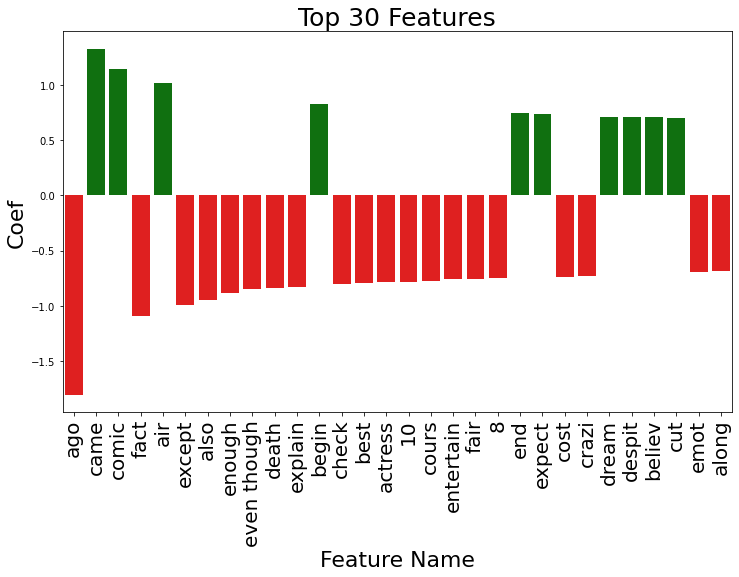

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df_plot.head(30),
           palette=df_plot.head(30)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 30 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

# 5.0 RNN (LSTM) model

Lets try using a sequence learner on the sentiment analysis dataset.

In [128]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.sequence import *
from keras.preprocessing.text import Tokenizer

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

## 5.1 Import & setup

In [129]:
from keras_preprocessing import sequence
from keras.utils import pad_sequences

We will use the imdb dataset rather than the DF we imported earlier as this data comes pre-padded and we need more than the fraction we took out of the df.

In [130]:
max_features = 6000
maxlen = 150  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')
y_train = y_train[:8000]
y_test = y_test[:8000]
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train[:8000], maxlen=maxlen)
X_test = sequence.pad_sequences(X_test[:8000], maxlen=maxlen)

print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (8000, 150)
x_test shape: (8000, 150)


## 5.2 Dataset visualisations

We see here it is tokenized and padded.

In [131]:
print(X_train[0]) 
print(len(X_train[0])) 

[  12   16   43  530   38   76   15   13 1247    4   22   17  515   17
   12   16  626   18    2    5   62  386   12    8  316    8  106    5
    4 2223 5244   16  480   66 3785   33    4  130   12   16   38  619
    5   25  124   51   36  135   48   25 1415   33    6   22   12  215
   28   77   52    5   14  407   16   82    2    8    4  107  117 5952
   15  256    4    2    7 3766    5  723   36   71   43  530  476   26
  400  317   46    7    4    2 1029   13  104   88    4  381   15  297
   98   32 2071   56   26  141    6  194    2   18    4  226   22   21
  134  476   26  480    5  144   30 5535   18   51   36   28  224   92
   25  104    4  226   65   16   38 1334   88   12   16  283    5   16
 4472  113  103   32   15   16 5345   19  178   32]
150


## 5.3 Create pipeline & fit

As we can see the training instances have been vectorised and padded - we have padded them to our maxlen size.

In [132]:
def LSTM_model(dropout, optimizer='adam', activation='sigmoid', max_features=6000, maxlen=150):

  print('Creating model.....')
  model = Sequential()
  model.add(Embedding(max_features, 128))
  model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(1, activation=activation))

  model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  model.summary()

  return model

In [133]:
keras_lstm_clf = KerasClassifier(build_fn=LSTM_model, verbose=1)

pipe = Pipeline([ 
    # ('tcp', text_cleanup_preprocessor), data is pre cleaned and processed
    # ('tpp', text_padding_preprocessor),
    ('clf', keras_lstm_clf)
])

params = {
    'clf__optimizer': ['rmsprop'],
    'clf__activation': [('sigmoid')],
    'clf__epochs': [10],
    'clf__dropout' : [(0.2)],
    'clf__batch_size' : [32]
}

pipe.get_params().keys() # show the params we can tune

<ipython-input-133-e8fcd674e7ef>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_lstm_clf = KerasClassifier(build_fn=LSTM_model, verbose=1)


dict_keys(['memory', 'steps', 'verbose', 'clf', 'clf__verbose', 'clf__build_fn'])

This will take some time to run - it is on the whole dataset.

In [ ]:
grid_lstm= GridSearchCV(pipe, params, scoring='accuracy', n_jobs=-1, cv=5, verbose=True)

grid_lstm.fit(X_train, y_train)

print(grid_lstm.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Creating model.....
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
782/782 [==============================] - 201s 253ms/step - loss: 0.6365 - accuracy: 0.7111
Epoch 2/10
782/782 [==============================] - 197s 252ms/step - loss: 0.5100 - accuracy: 0.8395
Epoch 3/10
782/782 [=

## 5.4 Investigate results

In [ ]:
best_ver1 = grid_lstm.best_estimator_
print("Test accuracy from all the models test data is: ", best_ver1.score(X_test, y_test))


782/782 [==============================] - 26s 33ms/step - loss: 1.5408 - accuracy: 0.8303
Test accuracy from all the models test data is:  0.8303200006484985


In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = best_ver1.predict(X_test)
result = confusion_matrix(y_test, y_pred , normalize='pred')


250/250 [==============================] - 15s 60ms/step


In [ ]:
print(result)

[[0.83811682 0.1785005 ]
 [0.16188318 0.8214995 ]]


The LSTM model took quite some time but still only was capable of accuracy similar to our other models, we could tune some parameters such as the batchsize and loss but litreature suggests that LSTM is very good at very large datasets and there isnt enough data here or time for it to be the clear choice.

Lets see how a CNN from keras will perform with some heavy param tuning.

Lets re-import the data and setup the values for training

# 5.0.0 Keras CNN

In [134]:
data_file = "https://raw.githubusercontent.com/nirmalie/CM4107/main/movie_data_cat.csv"
df = pd.read_csv(data_file,  encoding='utf-8')
print('Shape:', df.shape)

class_mapping = {label:idx for idx,label in enumerate(np.unique(df['sentiment']))}
df['sentiment'] = df['sentiment'].map(class_mapping)

Shape: (50000, 2)


In [140]:
small_df= df.sample(frac=0.1, replace=False, random_state=1)
X = small_df.loc[:, 'review'].values
y = small_df.loc[:, 'sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=42,
                                                          test_size=0.30, # lets use 30% for testing
                                                          stratify=y)
y_test_ohe = to_categorical(y_test, 2)
y_train_ohe = to_categorical(y_train, 2)
print('x_train shape:', X_train.shape)
print('y_train_ohe shape:', y_train_ohe.shape)
print('x_test shape:', X_test.shape)
print('y_test_ohe shape:', y_train_ohe.shape)
print(X_train[0:5])
print(y_train_ohe[0:5])


x_train shape: (3500,)
y_train_ohe shape: (3500, 2)
x_test shape: (1500,)
y_test_ohe shape: (3500, 2)
["This movie is about a fictional soap opera. It is very fast and funny. To say anything else would ruin the movie. There are several plots and sub plots in the movie. This movie has ensemble cast with today's hottest stars. They all gives over the top performances. This movie is favorite of mine from the year 1991. Soapdish is perfect for fans of either daytime soap opera /or prime time soap opera!!!If you watch soap go check this movie it's hilarious!!!"
 'Just after the end of WWII Powell & Pressburger were asked to come up with something to try to heal the rift developing between the UK & the USA. At the time there was a lot of "Overpaid, over sexed and over here" type of comments. Somehow they came up with this masterpiece.<br /><br />My favourite movie of ALL time. It\'s got everything. Romance, poetry, emotion, religion, drama and very quirky.<br /><br />I can never explain exac

In [165]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

In [166]:
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

In [177]:
def create_model(meta, hidden_layer_sizes=[128, 64], optimizer="adam", dropout=0.3):
    n_features_in_ = meta["n_features_in_"]
    print("n_features_in_", n_features_in_)
    n_classes_ = meta["n_classes_"]
    print("n_classes_", n_classes_)

    model = Sequential()
    model.add(Dense(256, activation='sigmoid', input_shape=(n_features_in_,)))
    model.add(Dropout(dropout) )

    for hidden_layer_size in hidden_layer_sizes:
        model.add(Dense ( hidden_layer_size, activation="sigmoid"))
        model.add(Dropout(dropout))

    model.add(Dense(n_classes_, activation="softmax"))
    print("meta", model.summary())
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
    return model

In [178]:
keras_clf = KerasClassifier(build_fn=create_model, verbose=1)# Wrapped Keras classifier

pipe = Pipeline([
    ('tcp', text_cleanup_preprocessor),
    ('vect', TfidfVectorizer()),
    ('fs',   SelectKBest(chi2)), # k finds the top features 
    ('clf', keras_clf)
])

params = {
    'vect__ngram_range': [(1,1)],# (1,2)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
    'vect__tokenizer': [tokenizer_stemmer, tokenizer], # use a tokeniser and the stemmer 
    'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
    'clf__optimizer': [('rmsprop')],
    'clf__batch_size': [(100)],
     'vect__min_df': [(25)],
      'vect__max_df': [(0.75)],
    'clf__epochs': [(25)],
    'fs__k': [(100), (250), (400)]
}



In [179]:
print(X_train.shape, y_train_ohe)

(3500,) [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [180]:
grid = GridSearchCV(pipe, params, n_jobs=-1, cv=3, verbose=True)

grid.fit(X_train, y_train_ohe)

print(grid.best_score_, grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
n_features_in_ 400
n_classes_ 2
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 256)               102656    
                                                                 
 dropout_48 (Dropout)        (None, 256)               0         
                                                                 
 dense_68 (Dense)            (None, 128)               32896     
                                                                 
 dropout_49 (Dropout)        (None, 128)               0         
                                                                 
 dense_69 (Dense)            (None, 64)                8256      
                                                                 
 dropout_50 (Dropout)        (None, 64)                0         
                          

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_19/dense_67/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_19/dense_67/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_19/dense_67/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


35/35 [==============================] - 1s 11ms/step - loss: 0.7314 - accuracy: 0.4917
Epoch 2/25
35/35 [==============================] - 0s 11ms/step - loss: 0.7165 - accuracy: 0.4900
Epoch 3/25
35/35 [==============================] - 0s 10ms/step - loss: 0.7039 - accuracy: 0.5054
Epoch 4/25
35/35 [==============================] - 0s 11ms/step - loss: 0.6986 - accuracy: 0.5103
Epoch 5/25
35/35 [==============================] - 0s 11ms/step - loss: 0.6982 - accuracy: 0.5049
Epoch 6/25
35/35 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.5191
Epoch 7/25
35/35 [==============================] - 0s 11ms/step - loss: 0.6864 - accuracy: 0.5426
Epoch 8/25
35/35 [==============================] - 0s 11ms/step - loss: 0.6740 - accuracy: 0.5831
Epoch 9/25
35/35 [==============================] - 0s 11ms/step - loss: 0.6286 - accuracy: 0.6683
Epoch 10/25
35/35 [==============================] - 0s 11ms/step - loss: 0.5320 - accuracy: 0.7503
Epoch 11/25
35/35 [=

## 5.0.1 Keras CNN results


In [181]:
imdb_clf = grid.best_estimator_
score = imdb_clf.score(X_test, y_test_ohe)
print('Test Accuracy: %.2f%%' % (score *100) )

# detailed report on test data using classification_report
y_pred_ohe = imdb_clf.predict(X_test)
print(classification_report(y_test_ohe, y_pred_ohe))

15/15 [==============================] - 0s 5ms/step
Test Accuracy: 84.47%
15/15 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       761
           1       0.85      0.83      0.84       739

   micro avg       0.84      0.84      0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500
 samples avg       0.84      0.84      0.84      1500



# 6.0 sms dataset exploration

Lets investigate and train models for a different dataset. 

The dataset we will use now is the df2 dataset (SMS spam).

The order of operations here will be as follows:
1. Investigate data
2. Create pipeline
3. Train pipeline
4. Evaluate
5. Conclude

Lets investigate the SMS spam data set.

So we have a similar situation here where the class value is either "ham or spam" then the sms_msg being text.

We will need to convert clas to a 1 or 0 then apply a similar type of pre-processing and vectorisation process to the sms_msg column too.

## 6.1 load & clean dataset

In [163]:
data_file2 = "https://raw.githubusercontent.com/nirmalie/CM4107/main/SMSSpamData.csv"

df2 = pd.read_csv(data_file2,  encoding='utf-8')
print('Shape:', df2.shape)

df2.head()

Shape: (5574, 2)


,class,sms_msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [164]:
num_classes = 2
class_mapping = {label:idx for idx,label in enumerate(np.unique(df2['class']))}

print("class_mapping:" , class_mapping)

#use the mapping dictionary to transform the class labels into integers

df2['class'] = df2['class'].map(class_mapping)
from tensorflow.keras.utils import to_categorical


class_mapping: {'ham': 0, 'spam': 1}


## 6.2 Visualise the dataset

Lets perform some similar visualisations for this dataset.

In [165]:
df2.head()

,class,sms_msg
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Train and test split for dataset #2

In [166]:
small_df= df2.sample(frac=0.5, replace=False, random_state=1)
X = small_df.loc[:, 'sms_msg'].values
y = small_df.loc[:, 'class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=1,
                                                          test_size=0.30, # lets use 30% for testing
                                                          stratify=y)
y_test_ohe = to_categorical(y_test, num_classes)
y_train_ohe = to_categorical(y_train, num_classes)
print('x_train shape:', X_train.shape)
print('y_train_ohe shape:', y_train_ohe.shape)
print('x_test shape:', X_test.shape)
print('y_test_ohe shape:', y_train_ohe.shape)
print(X_train[0:5])
print(y_train_ohe[0:5])

x_train shape: (1950,)
y_train_ohe shape: (1950, 2)
x_test shape: (837,)
y_test_ohe shape: (1950, 2)
['Great! I hope you like your man well endowed. I am  &lt;#&gt;  inches...'
 'Thanks again for your reply today. When is ur visa coming in. And r u still buying the gucci and bags. My sister things are not easy, uncle john also has his own bills so i really need to think about how to make my own money. Later sha.'
 'No calls..messages..missed calls'
 'Ok . . now i am in bus. . If i come soon i will come otherwise tomorrow'
 'Omg I want to scream. I weighed myself and I lost more weight! Woohoo!']
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [101]:
print(y_test_ohe[2])

[0. 1.]


In [102]:
df2=pd.DataFrame(X_train, columns=['messages'])
df2.head()
VOCAB_SIZE = set(df2['messages'].str.replace('[^a-zA-Z ]', '').str.lower().str.split(' ').sum())
print("Vocabulary approx size: ")
len(VOCAB_SIZE)

Vocabulary approx size: 


<ipython-input-102-7e7b36c459a2>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  VOCAB_SIZE = set(df2['messages'].str.replace('[^a-zA-Z ]', '').str.lower().str.split(' ').sum())


4818

Message length: 
Mean 81.45 words (59.069639) in a message


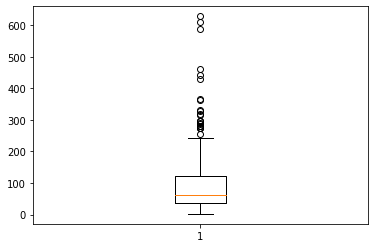

In [103]:
from matplotlib import pyplot

# Summarize review length
print("Message length: ")
result = [len(x) for x in df2.messages]
print("Mean %.2f words (%f) in a message" % (np.mean(result), np.std(result)))

AVG_REVIEW_LEN = np.mean(result)

# plot review length
pyplot.boxplot(result)
pyplot.show()

All of the above is similar to what was done for the first dataset, here we see the mean is around 60 words per message with some large outliers once again. Like before these outliers will be dealth with by selectkbest and the vectoriser we use.

In [79]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#  7.0 Create keras model & pipeline

In [80]:
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras
from keras.layers import Dropout, Activation


In [111]:
def create_model(meta, hidden_layer_sizes=[128, 64], optimizer="adam", dropout=0.2):
    n_features_in_ = meta["n_features_in_"]
    print("n_features_in_", n_features_in_)
    n_classes_ = meta["n_classes_"]
    print("n_classes_", n_classes_)

    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(n_features_in_,)))
    model.add(Dropout(dropout))

    for hidden_layer_size in hidden_layer_sizes:
        model.add(Dense ( hidden_layer_size, activation="relu"))
        model.add(Dropout(dropout))

    model.add(Dense(n_classes_, activation="softmax"))
    print("meta", model.summary())
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
    model.summary()

    return model

In [122]:
keras_clf = KerasClassifier(build_fn=create_model, verbose=1)# Wrapped Keras classifier

pipe = Pipeline([
    ('tcp', text_cleanup_preprocessor),
    ('vect', TfidfVectorizer()),
    ('fs',   SelectKBest(chi2)), # k finds the top features 
    ('clf', keras_clf)
])

params = {
    'vect__ngram_range': [(1,1)],
    'vect__tokenizer': [tokenizer_stemmer],
    'vect__stop_words': [None], # use the stop dictionary of stopwords or not
    'clf__optimizer': [('rmsprop')],
    'vect__min_df': [(12), (10)],
    'vect__max_df': [(0.4), (0.2)],
    'clf__batch_size': [(10)],
    'clf__epochs': [(20)],
    'fs__k': [(250)]
}

pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tcp', 'vect', 'fs', 'clf', 'tcp__accept_sparse', 'tcp__check_inverse', 'tcp__func', 'tcp__inv_kw_args', 'tcp__inverse_func', 'tcp__kw_args', 'tcp__validate', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__norm', 'vect__preprocessor', 'vect__smooth_idf', 'vect__stop_words', 'vect__strip_accents', 'vect__sublinear_tf', 'vect__token_pattern', 'vect__tokenizer', 'vect__use_idf', 'vect__vocabulary', 'fs__k', 'fs__score_func', 'clf__model', 'clf__build_fn', 'clf__warm_start', 'clf__random_state', 'clf__optimizer', 'clf__loss', 'clf__metrics', 'clf__batch_size', 'clf__validation_batch_size', 'clf__verbose', 'clf__callbacks', 'clf__validation_split', 'clf__shuffle', 'clf__run_eagerly', 'clf__epochs', 'clf__class_weight'])

In [123]:
grid = GridSearchCV(pipe, params, n_jobs=-1, cv=5, verbose=True)

grid.fit(X_train, y_train_ohe)

print(grid.best_score_, grid.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
n_features_in_ 250
n_classes_ 2
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 256)               64256     
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                           

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_10/dense_31/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_10/dense_31/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_10/dense_31/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


195/195 [==============================] - 2s 4ms/step - loss: 0.2310 - accuracy: 0.9133
Epoch 2/20
195/195 [==============================] - 1s 4ms/step - loss: 0.0517 - accuracy: 0.9831
Epoch 3/20
195/195 [==============================] - 1s 4ms/step - loss: 0.0282 - accuracy: 0.9923
Epoch 4/20
195/195 [==============================] - 1s 4ms/step - loss: 0.0184 - accuracy: 0.9944
Epoch 5/20
195/195 [==============================] - 1s 4ms/step - loss: 0.0137 - accuracy: 0.9949
Epoch 6/20
195/195 [==============================] - 1s 4ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 7/20
195/195 [==============================] - 1s 4ms/step - loss: 0.0022 - accuracy: 0.9995
Epoch 8/20
195/195 [==============================] - 1s 4ms/step - loss: 8.4043e-04 - accuracy: 1.0000
Epoch 9/20
195/195 [==============================] - 1s 4ms/step - loss: 0.0037 - accuracy: 0.9985
Epoch 10/20
195/195 [==============================] - 1s 4ms/step - loss: 0.0018 - accuracy: 0.9990
Epoch 

In [110]:
sms_clf = grid.best_estimator_
score = sms_clf.score(X_test, y_test_ohe)
print('Test Accuracy: %.2f%%' % (score *100) )

# detailed report on test data using classification_report
y_pred_ohe = sms_clf.predict(X_test)
print(classification_report(y_test_ohe, y_pred_ohe))

42/42 [==============================] - 0s 2ms/step
Test Accuracy: 97.49%
42/42 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       724
           1       0.90      0.92      0.91       113

   micro avg       0.97      0.97      0.97       837
   macro avg       0.94      0.95      0.95       837
weighted avg       0.98      0.97      0.98       837
 samples avg       0.97      0.97      0.97       837



# 8.0 use gsearch function on dataset 2

This is quite a good performance result. 

It is interesting to see that the model preferred the data without the stop words, this is probably due to the fact that ANN models can learn complex relationships and using stop words in the pipeline reduces the dimensionality of the dataset hence being detrimental for the performance.

In [173]:
smaller_df = df2.sample(frac=0.5, replace=False, random_state=1)
# remove the HTML and punctuation to speed up text processing

smaller_df['sms_msg'] = smaller_df['sms_msg'].apply(preprocessor)

X = small_df.loc[:, 'sms_msg'].values
y = small_df.loc[:, 'class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=42,
                                                          test_size=0.30, # 30% for testing
                                                          stratify=y)
print("Sample of Training data:", X_train.shape)
print("Sample of Test data:", X_test.shape)

Sample of Training data: (1950,)
Sample of Test data: (837,)


In [185]:
# similar to how we tested the sklearn models for the imbd datset
models = []
best_models = []
models.append(('LR', LogisticRegression(), [('max_iter', [128]), ('solver', [('lbfgs')]), ('multi_class', ['auto'])]))
models.append(('SVM', SVC( gamma=0.1, C=1.0), [('kernel', [('linear'), ('poly')])]))
# we started with a keras CNN so no point in using sklearns
models.append(('KNN', KNeighborsClassifier(), [('n_neighbors', [(3), (5)])]))
models.append(('RF', RandomForestClassifier(random_state=42),[('n_estimators', [(200)]), ('max_depth', [(70)])]))



pre_processtext_grid = [{'vector__ngram_range': [(1,1), (1, 2)], 
               'vector__stop_words': [stop],  
               'vector__tokenizer': [tokenizer_stemmer, tokenizer], 
               'vector__min_df': [(10)],
               'vector__max_df': [(0.8)],
               }]
tfidf = TfidfVectorizer(strip_accents=None,
                         lowercase=False,
                         preprocessor=None)

plot_data = gsearch(models, X_train, y_train, X_test, y_test, tfidf, pre_processtext_grid)
print(plot_data) 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter set: {'model__max_iter': 128, 'model__multi_class': 'auto', 'model__solver': 'lbfgs', 'vector__max_df': 0.8, 'vector__min_df': 10, 'vector__ngram_range': (1, 1), 'vector__stop_words': {'being', "aren't", 'below', 'them', 'then', 'she', 'under', 'here', 'having', 'above', 'other', 'some', 'any', 'haven', 'ma', 'while', 'our', 'am', 'whom', 'doesn', 'he', 'few', 'which', 'so', "it's", 'where', 's', "you'd", 'you', 'couldn', 'shouldn', 'out', 'an', "mightn't", 'once', 'but', 'such', "she's", 'ourselves', 'herself', 'itself', 'shan', "needn't", 'be', "hasn't", "wouldn't", 'because', 'the', 'don', 'doing', 'about', "you'll", "haven't", "should've", 't', 'had', 'of', 'aren', 'me', 'yourself', 'ours', 'when', 'has', "shouldn't", "don't", 'just', "didn't", 'wasn', 'between', 'its', 'again', 'ain', 'mightn', 've', "wasn't", 'or', "you've", 'during', 'll', 'this', 'more', 'off', 'against', 'there', 'your', 'at', 'y', 'mus

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn(


Best parameter set: {'model__kernel': 'linear', 'vector__max_df': 0.8, 'vector__min_df': 10, 'vector__ngram_range': (1, 1), 'vector__stop_words': {'being', "aren't", 'below', 'them', 'then', 'she', 'under', 'here', 'having', 'above', 'other', 'some', 'any', 'haven', 'ma', 'while', 'our', 'am', 'whom', 'doesn', 'he', 'few', 'which', 'so', "it's", 'where', 's', "you'd", 'you', 'couldn', 'shouldn', 'out', 'an', "mightn't", 'once', 'but', 'such', "she's", 'ourselves', 'herself', 'itself', 'shan', "needn't", 'be', "hasn't", "wouldn't", 'because', 'the', 'don', 'doing', 'about', "you'll", "haven't", "should've", 't', 'had', 'of', 'aren', 'me', 'yourself', 'ours', 'when', 'has', "shouldn't", "don't", 'just', "didn't", 'wasn', 'between', 'its', 'again', 'ain', 'mightn', 've', "wasn't", 'or', "you've", 'during', 'll', 'this', 'more', 'off', 'against', 'there', 'your', 'at', 'y', 'mustn', 'further', 'my', 'needn', 'theirs', 'these', 'most', 'than', 'were', 'now', "couldn't", 'weren', 'himself', 

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn(


Best parameter set: {'model__max_depth': 70, 'model__n_estimators': 200, 'vector__max_df': 0.8, 'vector__min_df': 10, 'vector__ngram_range': (1, 1), 'vector__stop_words': {'being', "aren't", 'below', 'them', 'then', 'she', 'under', 'here', 'having', 'above', 'other', 'some', 'any', 'haven', 'ma', 'while', 'our', 'am', 'whom', 'doesn', 'he', 'few', 'which', 'so', "it's", 'where', 's', "you'd", 'you', 'couldn', 'shouldn', 'out', 'an', "mightn't", 'once', 'but', 'such', "she's", 'ourselves', 'herself', 'itself', 'shan', "needn't", 'be', "hasn't", "wouldn't", 'because', 'the', 'don', 'doing', 'about', "you'll", "haven't", "should've", 't', 'had', 'of', 'aren', 'me', 'yourself', 'ours', 'when', 'has', "shouldn't", "don't", 'just', "didn't", 'wasn', 'between', 'its', 'again', 'ain', 'mightn', 've', "wasn't", 'or', "you've", 'during', 'll', 'this', 'more', 'off', 'against', 'there', 'your', 'at', 'y', 'mustn', 'further', 'my', 'needn', 'theirs', 'these', 'most', 'than', 'were', 'now', "couldn

## 8.1 Graph dataset 2's results

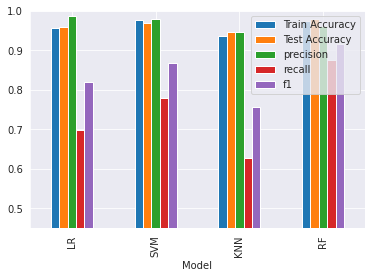

In [186]:
plot_data.plot.bar(x='Model', ylim=(.45, 1.))

## 8.2 feature importance for dataset 2 model

In [194]:
i = best_models[0]
print(i.named_steps["model"])
print(i.named_steps["model"].coef_[0][:5])
# first 5 coefs from the LR model to see what the values look like

LogisticRegression(max_iter=128)
[0.76883202 1.94781892 0.94301367 1.25687642 1.30112061]


In [189]:
feature_names = i.named_steps["vector"].get_feature_names_out()
print(len(feature_names))
print(feature_names[:20])

358
['000' '1' '10' '100' '1000' '150p' '150ppm' '16' '18' '2' '2nd' '3' '4'
 '5' '50' '500' '6' '7' '8' '9']


In [190]:
coefs = i.named_steps["model"].coef_.flatten()

# print(coefs)
# prepare the coefs for graphing/visualisation

In [191]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)
df_plot = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df_plot["abs_value"] = df_plot["value"].apply(lambda x: abs(x))
df_plot["colors"] = df_plot["value"].apply(lambda x: "green" if x > 0 else "red")
df_plot = df_plot.sort_values("abs_value", ascending=False)

Text(0.5, 0, 'Feature Name')

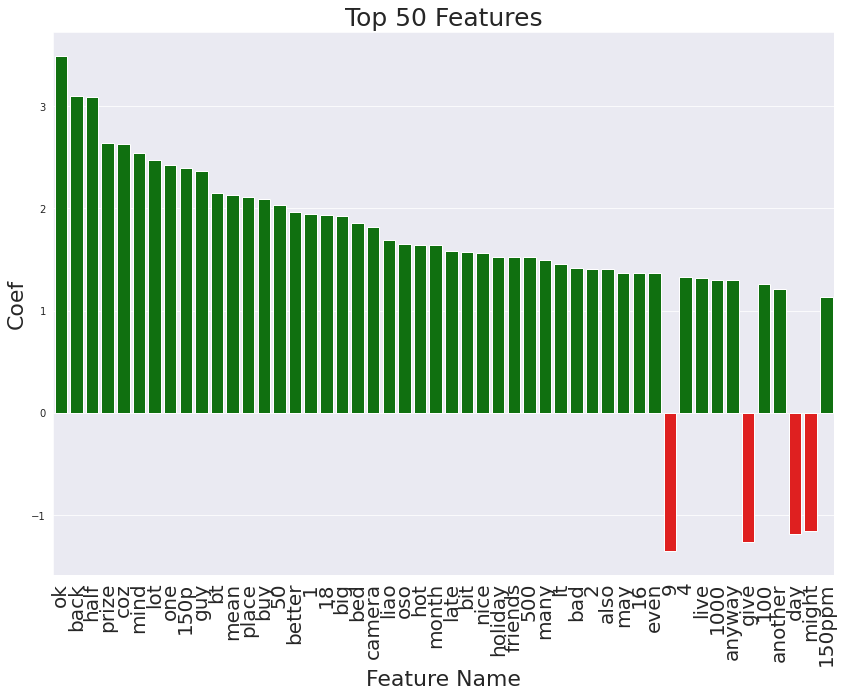

In [195]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
sns.barplot(x="feature",
            y="value",
            data=df_plot.head(50),
           palette=df_plot.head(50)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 50 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)